## Setup
Import necessary libraries and employ TPU as accelerator.

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

import shutil
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    tf.keras.mixed_precision.set_global_policy('mixed_bfloat16')
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

D0903 03:06:29.783655070      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0903 03:06:29.783679318      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0903 03:06:29.783693560      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0903 03:06:29.783696435      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0903 03:06:29.783698866      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0903 03:06:29.783701630      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0903 03:06:29.783704117      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0903 03:06:29.

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


/usr/local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:lo

## Preprocess
Read images from Tensorflow Records and convert image values to range -1 and 1. Then I employ random jitter and random flip as data augmentation.

In [2]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, 286, 286)
    image = tf.image.random_crop(image, size=[*IMAGE_SIZE, 3])
    image = tf.image.random_flip_left_right(image)

    return image * 2 - 1

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(files):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

monet_dataset = load_dataset(tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'))
photo_dataset = load_dataset(tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'))

View monet image and photo examples via matplotlib.

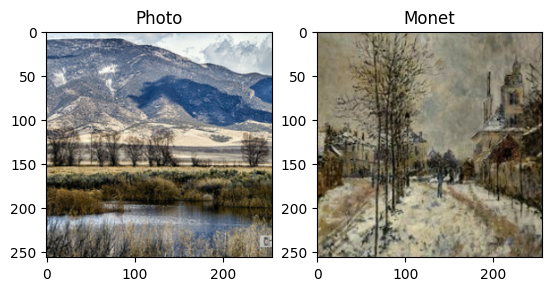

In [3]:
example_monet = next(iter(monet_dataset))
example_photo = next(iter(photo_dataset))

plt.subplot(1,2,1)
plt.title('Photo')
plt.imshow((example_photo+1)/2)

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow((example_monet+1)/2)

Since CycleGAN employs Instance Normalization as normalization layer, I have to set batch size 1 for the training and testing datasets.

In [4]:
monet_dataset = monet_dataset.prefetch(32).shuffle(32).batch(1)
photo_dataset = photo_dataset.prefetch(32).shuffle(32).batch(1)

## Model Arch
There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

Generator G learns to transform image X to image Y. 
Generator F learns to transform image Y to image X. 
Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).
Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$
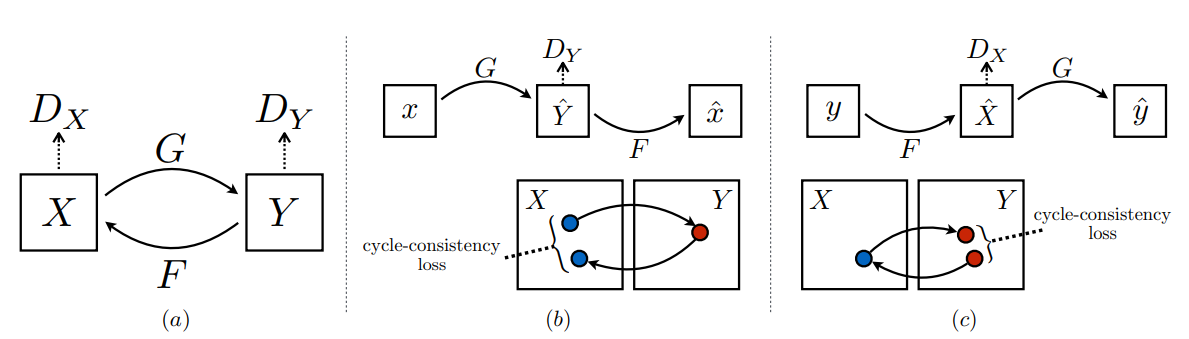

In [5]:
kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


class ReflectionPadding2D(tf.keras.layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = tf.keras.layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=deepcopy(kernel_initializer),
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=deepcopy(gamma_initializer))(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = tf.keras.layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=deepcopy(kernel_initializer),
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=deepcopy(gamma_initializer))(x)
    x = tf.keras.layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = tf.keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=deepcopy(kernel_initializer),
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=deepcopy(gamma_initializer))(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = tf.keras.layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=deepcopy(kernel_initializer),
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=deepcopy(gamma_initializer))(x)
    if activation:
        x = activation(x)
    return x

In [6]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = tf.keras.Input(shape=[*IMAGE_SIZE, 3], name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = tf.keras.layers.Conv2D(filters, (7, 7), kernel_initializer=deepcopy(kernel_initializer), use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=deepcopy(gamma_initializer))(x)
    x = tf.keras.layers.ReLU()(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=tf.keras.layers.ReLU())

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=tf.keras.layers.ReLU())

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=tf.keras.layers.ReLU())

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = tf.keras.layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = tf.keras.layers.Activation("tanh")(x)

    model = tf.keras.Model(img_input, x, name=name)
    return model

In [7]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = tf.keras.Input(shape=[*IMAGE_SIZE, 3], name=name + "_img_input")
    x = tf.keras.layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=deepcopy(kernel_initializer),
    )(img_input)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=tf.keras.layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=tf.keras.layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = tf.keras.layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=deepcopy(kernel_initializer)
    )(x)

    model = tf.keras.Model(inputs=img_input, outputs=x, name=name)
    return model


with strategy.scope():
    # Get the generators
    gen_G = get_resnet_generator(name="generator_G")
    gen_F = get_resnet_generator(name="generator_F")

    # Get the discriminators
    disc_X = get_discriminator(name="discriminator_X")
    disc_Y = get_discriminator(name="discriminator_Y")

In [8]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.SUM)
        self.identity_loss_fn = tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.SUM)

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

Losses calculation as follows:
* Adversarial Loss: 

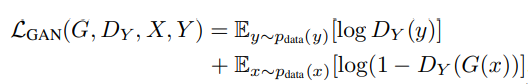
* Cycle Consistency Loss:

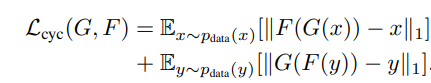
* Full Objective Loss:

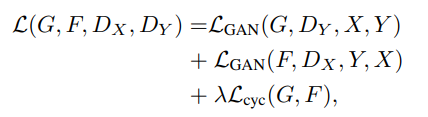

Training loop consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [9]:
# Loss function for evaluating adversarial loss
adv_loss_fn = tf.keras.losses.MeanSquaredError(tf.keras.losses.Reduction.SUM)

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
with strategy.scope():
    cycle_gan_model = CycleGan(
        generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
    )

    # Compile the model
    cycle_gan_model.compile(
        gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_loss_fn=generator_loss_fn,
        disc_loss_fn=discriminator_loss_fn,
    )

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=10,
)
cycle_gan_model.save_weights('./model_checkpoints/ckpt')

Epoch 1/10


2023-09-03 03:08:14.499596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-03 03:08:16.656779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 454s 659ms/step - G_loss: 301135.9468 - F_loss: 278439.5482 - D_X_loss: 67.5868 - D_Y_loss: 89.4982
Epoch 2/10
300/300 [==============================] - 197s 657ms/step - G_loss: 270099.5615 - F_loss: 254411.2691 - D_X_loss: 19.3517 - D_Y_loss: 47.4257
Epoch 3/10
300/300 [==============================] - 198s 659ms/step - G_loss: 253149.1296 - F_loss: 243228.9169 - D_X_loss: 28.7303 - D_Y_loss: 20.0656
Epoch 4/10
300/300 [==============================] - 197s 657ms/step - G_loss: 240015.7342 - F_loss: 229358.9900 - D_X_loss: 20.7481 - D_Y_loss: 20.6090
Epoch 5/10
300/300 [==============================] - 198s 658ms/step - G_loss: 228751.7342 - F_loss: 221427.2425 - D_X_loss: 8.9919 - D_Y_loss: 20.2670
Epoch 6/10
300/300 [==============================] - 198s 659ms/step - G_loss: 226588.0664 - F_loss: 214516.0930 - D_X_loss: 6.9693 - D_Y_loss: 13.2124
Epoch 7/10
300/300 [==============================] - 198s 659ms/step - G_loss: 221680.69

## Evaluate
Evaluate on test dataset. Then archive moneted images to a zip file.

In [ ]:
def read_tfrecord_infer(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image, example['image_name']

dataset = tf.data.TFRecordDataset(tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'))
dataset = dataset.map(read_tfrecord_infer, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.prefetch(32).batch(1)

In [ ]:
cycle_gan_model.load_weights('./model_checkpoints/ckpt')
tf.io.gfile.rmtree('./images')
tf.io.gfile.makedirs('./images')
for image, image_name in dataset:
    monet_photo = cycle_gan_model.gen_G(image, training=False)
    monet_photo = tf.cast(monet_photo * 127.5 + 127.5, tf.uint8)
    jpeg_image = tf.io.encode_jpeg(monet_photo[0], 'rgb')
    tf.io.write_file(f'./images/{image_name[0].numpy().decode("utf-8")}.jpg', jpeg_image)

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "./images")

## Conclusion
CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain.

There are several aspects worth to explore, such as lambda value, learning rate and beta value. Training more epochs may also help improve model performance.

Note the batch size must be 1, otherwise the model can't get SOTA performance, since there are Instance Normalizations in the model.